## Business Problem

Out task is to build network intrusion detection system to detect anamolies and attacks in the network. 
There are two problems.
    1. Binomial Classification: Activity is normal or attack
    2. Multinomial classification: Activity is normal or DOS or PROBE or R2L or U2R

### Statistical Problem

Our objective is to detect maximum anamolies and attacks in the  network

Each sample represent each network connection amd related information

### Import Packages

In [152]:
#fror data manipulation
import numpy as np
import pandas as pd

#for charts and graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [153]:
#for statistical tests
import scipy.stats as stats

In [154]:
#for pandas profiling
import pandas_profiling

In [155]:
#for modelling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#for crossvalidation
from sklearn.model_selection import GridSearchCV

In [156]:
#for metrics
from sklearn import metrics

### Data Import

In [157]:
conn_data_train = pd.read_csv('Train.txt', header = None)
conn_data_test = pd.read_csv('Test.txt', header = None)

In [158]:
conn_data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [159]:
#As training set do not have columns defined, we will add columns to the dataset

col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
                     "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised",
                     "root_shell","su_attempted","num_root","num_file_creations", "num_shells",
                     "num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count",
                     "srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate",
                     "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                     "dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                     "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
conn_data_train.columns = col_names
conn_data_test.columns = col_names

In [160]:
conn_data_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### Profiling to understand the types and relationship of variables

In [161]:
profile_connection = conn_data_train.profile_report()

In [248]:
#Exporting it as an html file
profile_connection.to_file('profile_connection.html')

### Data Inspection

#### 1. Identify dependent variable(Y)

In [163]:
#'attack' variable is our Y variable

#For binomial classification we convert attack variable as 0-1

#0- normal
#1- values other than normal(attack)

#saving in new df to use for multinomial classification
conn_attack_train = pd.DataFrame()
conn_attack_train['attack'] = conn_data_train['attack']

conn_data_train['attack'] = conn_data_train.attack.apply(lambda x : 0 if (x.lower() == 'normal') else 1)

#--------Repeating same transformation for test data----------------#

conn_attack_test = pd.DataFrame()
conn_attack_test['attack'] = conn_data_test['attack']

conn_data_test['attack'] = conn_data_test.attack.apply(lambda x : 0 if (x.lower() == 'normal') else 1)

In [164]:
conn_data_train.attack.head()

0    0
1    0
2    1
3    0
4    0
Name: attack, dtype: int64

In [165]:
conn_data_train.shape

(125973, 43)

#### 2. Separate continous and categorical features

In [166]:
conn_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [167]:
#sns.distplot(conn_data_train.hot)

In [168]:
#Should be considered as cat-hot, num_failed_logins, 
#Should not be considered as cat-num_access_files, last_flag

#num_outbound_cmds has a constant value and should ignored as it is not bringing any varinace in the data

cat_var_list = ['protocol_type', 'service', 'flag', 'land', 'wrong_fragment', 'urgent', 'logged_in',
                'root_shell', 'su_attempted', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login',
               ]

In [169]:
#list of all categorical variables
cat_var_train = conn_data_train[cat_var_list]
cat_var_train.head()
print(cat_var_train.shape)

#list of all categorical variables
cat_var_test = conn_data_test[cat_var_list]
cat_var_test.head()
print(cat_var_test.shape)

(125973, 13)
(22544, 13)


In [170]:
#cat_var_list.extend(['attack'])
cat_var_list

['protocol_type',
 'service',
 'flag',
 'land',
 'wrong_fragment',
 'urgent',
 'logged_in',
 'root_shell',
 'su_attempted',
 'num_shells',
 'num_access_files',
 'is_host_login',
 'is_guest_login']

In [171]:
conn_data_train.columns.difference(cat_var_list)

Index(['attack', 'count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate',
       'dst_host_srv_serror_rate', 'duration', 'hot', 'last_flag',
       'num_compromised', 'num_failed_logins', 'num_file_creations',
       'num_outbound_cmds', 'num_root', 'rerror_rate', 'same_srv_rate',
       'serror_rate', 'src_bytes', 'srv_count', 'srv_diff_host_rate',
       'srv_rerror_rate', 'srv_serror_rate'],
      dtype='object')

In [172]:
#list of all continous variables
cont_var_train = conn_data_train[conn_data_train.columns.difference(cat_var_list)]
cont_var_test = conn_data_test[conn_data_test.columns.difference(cat_var_list)]
cont_var_train.head()

,attack,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,...,num_outbound_cmds,num_root,rerror_rate,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate
0,0,2,0.00,0,150,0.03,0.05,0.17,0.17,0.00,...,0,0,0.0,1.00,0.0,491,2,0.00,0.0,0.0
1,0,13,0.15,0,255,0.60,0.00,0.88,0.00,0.00,...,0,0,0.0,0.08,0.0,146,1,0.00,0.0,0.0
2,1,123,0.07,0,255,0.05,0.00,0.00,0.10,1.00,...,0,0,0.0,0.05,1.0,0,6,0.00,0.0,1.0
3,0,5,0.00,8153,30,0.00,0.00,0.03,1.00,0.03,...,0,0,0.0,1.00,0.2,232,5,0.00,0.0,0.2
4,0,30,0.00,420,255,0.00,0.00,0.00,1.00,0.00,...,0,0,0.0,1.00,0.0,199,32,0.09,0.0,0.0


In [173]:
def continous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),x.std(),
                      x.var(), x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), x.quantile(0.25),
                      x.quantile(0.50), x.quantile(0.75), x.quantile(0.90), x.quantile(0.95), 
                      x.quantile(0.99), x.max()],
                    index = ['N', 'NMiss', 'Sum', 'Mean', 'Median', 'SD', 'Var', 'Min', 'P1', 'P5', 'P10','P25',
                            'P50', 'P75', 'P90', 'P95', 'P99', 'Max'])
    

In [174]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0,1],
                     round((Mode.iloc[0,1]*100)/x.count(), 2)],
                     index = ['N', 'NMiss', 'Mode', 'Freq', 'Percent'])

In [175]:
#function for creating dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first= True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace= True)
    return df

### Data Inspection

In [176]:
cont_var_summary = cont_var_train.apply(lambda x : continous_var_summary(x)).T.round(1)
cont_var_summary

,N,NMiss,Sum,Mean,Median,SD,Var,Min,P1,P5,P10,P25,P50,P75,P90,P95,P99,Max
attack,125973.0,0.0,5.863000e+04,0.5,0.0,0.5,2.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.000000e+00
count,125973.0,0.0,1.059528e+07,84.1,14.0,114.5,1.311220e+04,0.0,1.0,1.0,1.0,2.0,14.0,143.0,256.0,286.0,511.0,5.110000e+02
diff_srv_rate,125973.0,0.0,7.942900e+03,0.1,0.0,0.2,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.3,1.0,1.000000e+00
dst_bytes,125973.0,0.0,2.491634e+09,19779.1,0.0,4021269.2,1.617061e+13,0.0,0.0,0.0,0.0,0.0,0.0,516.0,3375.8,8314.0,25519.0,1.309937e+09
dst_host_count,125973.0,0.0,2.294585e+07,182.1,255.0,99.2,9.841900e+03,0.0,1.0,3.0,11.0,82.0,255.0,255.0,255.0,255.0,255.0,2.550000e+02
dst_host_diff_srv_rate,125973.0,0.0,1.044960e+04,0.1,0.0,0.2,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.6,1.0,1.000000e+00
dst_host_rerror_rate,125973.0,0.0,1.496960e+04,0.1,0.0,0.3,1.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,1.0,1.0,1.000000e+00
dst_host_same_src_port_rate,125973.0,0.0,1.869170e+04,0.1,0.0,0.3,1.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.8,1.0,1.0,1.000000e+00
dst_host_same_srv_rate,125973.0,0.0,6.566240e+04,0.5,0.5,0.4,2.000000e-01,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.000000e+00
dst_host_serror_rate,125973.0,0.0,3.583330e+04,0.3,0.0,0.4,2.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.000000e+00


In [177]:
cat_var_summary = cat_var_train.apply(lambda x : categorical_var_summary(x)).T
cat_var_summary

,N,NMiss,Mode,Freq,Percent
protocol_type,125973,0,tcp,102689,81.52
service,125973,0,http,40338,32.02
flag,125973,0,SF,74945,59.49
land,125973,0,0,125948,99.98
wrong_fragment,125973,0,0,124883,99.13
urgent,125973,0,0,125964,99.99
logged_in,125973,0,0,76121,60.43
root_shell,125973,0,0,125804,99.87
su_attempted,125973,0,0,125893,99.94
num_shells,125973,0,0,125926,99.96


### Data Cleaning

#### Outlier treatment

In [178]:
cont_var_train = cont_var_train.apply(lambda x : x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))
cont_var_test = cont_var_test.apply(lambda x : x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [179]:
cont_var_train.apply(lambda x : continous_var_summary(x)).T

,N,NMiss,Sum,Mean,Median,SD,Var,Min,P1,P5,P10,P25,P50,P75,P90,P95,P99,Max
attack,125973.0,0.0,5.863000e+04,0.465417,0.00,0.498805,2.488060e-01,0.0,0.0,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.0000,1.00
count,125973.0,0.0,1.059529e+07,84.107658,14.00,114.508532,1.311220e+04,1.0,1.0,1.00,1.00,2.00,14.00,143.00,256.00,286.00,511.0000,511.00
diff_srv_rate,125973.0,0.0,7.942930e+03,0.063053,0.00,0.180314,3.251329e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.06,0.07,0.29,1.0000,1.00
dst_bytes,125973.0,0.0,1.690707e+08,1342.118549,0.00,3804.294003,1.447265e+07,0.0,0.0,0.00,0.00,0.00,0.00,516.00,3375.80,8314.00,25519.0000,25519.00
dst_host_count,125973.0,0.0,2.294585e+07,182.148968,255.00,99.206169,9.841864e+03,1.0,1.0,3.00,11.00,82.00,255.00,255.00,255.00,255.00,255.0000,255.00
dst_host_diff_srv_rate,125973.0,0.0,1.044960e+04,0.082951,0.02,0.188922,3.569145e-02,0.0,0.0,0.00,0.00,0.00,0.02,0.07,0.10,0.56,1.0000,1.00
dst_host_rerror_rate,125973.0,0.0,1.496960e+04,0.118832,0.00,0.306557,9.397748e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.84,1.00,1.0000,1.00
dst_host_same_src_port_rate,125973.0,0.0,1.869173e+04,0.148379,0.00,0.308997,9.547923e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.06,0.84,1.00,1.0000,1.00
dst_host_same_srv_rate,125973.0,0.0,6.566238e+04,0.521242,0.51,0.448949,2.015555e-01,0.0,0.0,0.00,0.01,0.05,0.51,1.00,1.00,1.00,1.0000,1.00
dst_host_serror_rate,125973.0,0.0,3.583333e+04,0.284452,0.00,0.444784,1.978329e-01,0.0,0.0,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.0000,1.00


### Dummy Creation 

In [180]:
#We cannot use categorical variables as it is more out modelling, hence we need to create dummies out of them.
cat_var_list = list(cat_var_train.columns)
cat_var_list

['protocol_type',
 'service',
 'flag',
 'land',
 'wrong_fragment',
 'urgent',
 'logged_in',
 'root_shell',
 'su_attempted',
 'num_shells',
 'num_access_files',
 'is_host_login',
 'is_guest_login']

In [181]:
for c_feature in cat_var_list:
    cat_var_train[c_feature] = cat_var_train[c_feature].astype('category')
    cat_var_train = create_dummies(cat_var_train, c_feature)
    
for c_feature in cat_var_list:
    cat_var_test[c_feature] = cat_var_test[c_feature].astype('category')
    cat_var_test = create_dummies(cat_var_test, c_feature)

C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [182]:
cat_var_train.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,...,num_access_files_2,num_access_files_3,num_access_files_4,num_access_files_5,num_access_files_6,num_access_files_7,num_access_files_8,num_access_files_9,is_host_login_1,is_guest_login_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
cat_var_test.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,...,su_attempted_2,num_shells_1,num_shells_2,num_shells_5,num_access_files_1,num_access_files_2,num_access_files_3,num_access_files_4,is_host_login_1,is_guest_login_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Combining feature variables for modelling

In [184]:
conn_data_train_new = pd.concat([cont_var_train, cat_var_train], axis = 1)
conn_data_train_new.head()

,attack,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,...,num_access_files_2,num_access_files_3,num_access_files_4,num_access_files_5,num_access_files_6,num_access_files_7,num_access_files_8,num_access_files_9,is_host_login_1,is_guest_login_1
0,0,2,0.00,0,150,0.03,0.05,0.17,0.17,0.00,...,0,0,0,0,0,0,0,0,0,0
1,0,13,0.15,0,255,0.60,0.00,0.88,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,1,123,0.07,0,255,0.05,0.00,0.00,0.10,1.00,...,0,0,0,0,0,0,0,0,0,0
3,0,5,0.00,8153,30,0.00,0.00,0.03,1.00,0.03,...,0,0,0,0,0,0,0,0,0,0
4,0,30,0.00,420,255,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0


In [185]:
conn_data_test_new = pd.concat([cont_var_test, cat_var_test], axis = 1)
conn_data_test_new.head()

,attack,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,...,su_attempted_2,num_shells_1,num_shells_2,num_shells_5,num_access_files_1,num_access_files_2,num_access_files_3,num_access_files_4,is_host_login_1,is_guest_login_1
0,1,229,0.06,0.0,255,0.06,1.00,0.00,0.04,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,136,0.06,0.0,255,0.06,1.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0.00,0.0,134,0.04,0.00,0.61,0.61,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0.00,0.0,3,0.00,0.00,1.00,1.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0.00,15.0,29,0.17,0.83,0.03,0.31,0.0,...,0,0,0,0,0,0,0,0,0,0


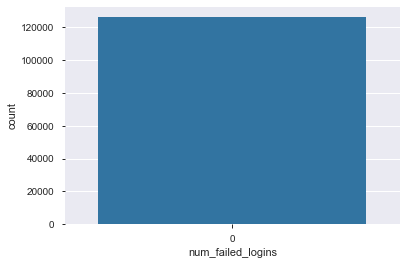

In [186]:
sns.countplot(conn_data_train_new.num_failed_logins)

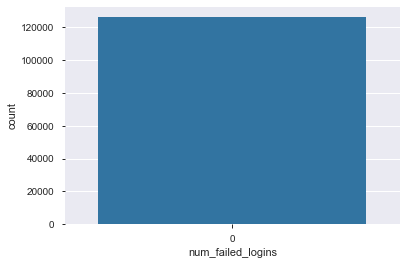

In [187]:
sns.countplot(conn_data_train_new.num_failed_logins)

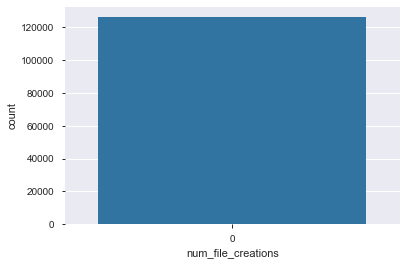

In [188]:
sns.countplot(conn_data_train_new.num_file_creations)

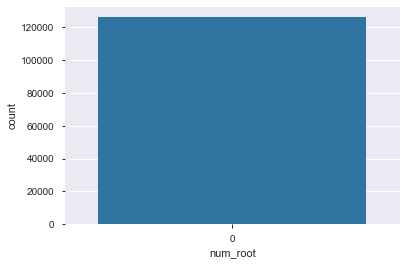

In [189]:
sns.countplot(conn_data_train_new.num_root)

In [190]:
#as variables num_failed_logins,num_file_creations, num_outbound_cmds, num_root is constant so droping this vraible

conn_data_train_new.drop(columns= ['num_failed_logins','num_file_creations', 'num_outbound_cmds', 'num_root'], inplace=True)

conn_data_test_new.drop(columns= ['num_failed_logins','num_file_creations', 'num_outbound_cmds', 'num_root'], inplace=True)

In [278]:
# Creating correlation matrix for checking milticollinearity
corr_network = conn_data_train_new.corr()

In [183]:
corr_network.to_excel('corr_network.xlsx')

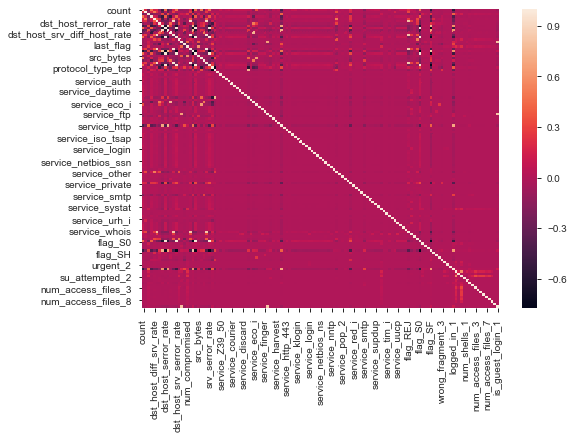

In [184]:
sns.heatmap(corr_network)

#### Analyzing Y variable

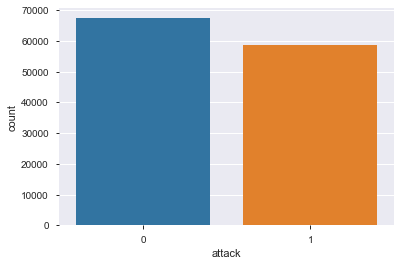

In [191]:
sns.countplot(conn_data_train.attack)

In [192]:
# from above we can see that the train data is not too much skewed towards any class, 
# so we can go ahead for modelling without any transformations

### Mapping test feature columns as per train columns

In [193]:
# Get missing columns in the training test
missing_cols = set(conn_data_train_new.columns ) - set( conn_data_test_new.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    conn_data_test_new[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
conn_data_test_new = conn_data_test_new[conn_data_train_new.columns]

In [194]:
conn_data_train_new.shape

(125973, 130)

In [195]:
conn_data_test_new.shape

(22544, 130)

### Model Building

#### 1. Divide the data into train and test


In [196]:
#conn_data_train['attack'] = conn_data_train.attack.apply(lambda x : 0 if (x.lower() == 'normal') else 1)
#conn_data_test['attack'] = conn_data_test.attack.apply(lambda x : 0 if (x.lower() == 'normal') else 1)

In [197]:
feature_columns = conn_data_train_new.columns.difference(['attack'])
feature_columns

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       ...
       'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate',
       'su_attempted_1', 'su_attempted_2', 'urgent_1', 'urgent_2', 'urgent_3',
       'wrong_fragment_1', 'wrong_fragment_3'],
      dtype='object', length=129)

In [198]:
train_x, test_x, train_y, test_y = train_test_split(conn_data_train_new[feature_columns],
                                                   conn_data_train_new['attack'], test_size = 0.3, random_state = 222)
print('No. of observation train: ' , train_x.shape[0], ' | ', 'No. of observation test: ' ,test_x.shape[0])

No. of observation train:  88181  |  No. of observation test:  37792


#### 2. Define the model

We will use random forest classifier for binomial classification

In [199]:
para_grid_rf = {'n_estimators' : [50,70,80,90,100],
                'max_features' : [19,20,21,22,23,24]}

gscv_rf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=para_grid_rf,
                       cv = 10,
                       verbose = 2,
                       n_jobs =-1)

gscv_rf.fit(train_x, train_y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [200]:
gscv_rf.best_score_

0.9995804075773942

In [201]:
gscv_rf.best_params_

{'max_features': 21, 'n_estimators': 80}

In [202]:
gscv_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=21,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 3. Fit/process the model based on best parameteres obtained via cross validation

In [203]:
rf = gscv_rf.best_estimator_

#rf = RandomForestClassifier(oob_score=True, n_estimators= 110)
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=21,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 4. Prdict the output for train and validation set

In [204]:
rf_train_predict = pd.DataFrame({'actual' : train_y,
                                 'predicted' : rf.predict(train_x)})
rf_train_predict.head()

,actual,predicted
78568,0,0
39227,0,0
45717,0,0
57392,1,1
101330,1,1


In [205]:
rf_test_predict = pd.DataFrame({'actual' : test_y,
                                'predicted' : rf.predict(test_x)})
rf_test_predict.head()

,actual,predicted
14905,0,0
106035,1,1
45839,1,1
19192,0,0
59564,0,0


#### Predicting on testing data

In [209]:
test_predicted = rf.predict(conn_data_test_new[feature_columns])

In [210]:
test_predicted

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

### Model Validation

In [211]:
#1. Check accuracy score on train and test

print('Accuracy Score for train dataset : ' , metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted))
print('Accuracy Score for validation dataset : ' , metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted))

print('Accuracy Score for test dataset : ' , metrics.accuracy_score(conn_data_test_new.attack, test_predicted))

Accuracy Score for train dataset :  1.0
Accuracy Score for validation dataset :  0.9997353937341237
Accuracy Score for test dataset :  0.8463005677785663


In [212]:
#2. Check roc_auc score on train and test

print('ROC-AUC Score for train dataset : ' , metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted))
print('ROC-AUC Score for validation dataset : ' , metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted))

print('ROC-AUC Score for test dataset : ' , metrics.roc_auc_score(conn_data_test_new.attack, test_predicted))

ROC-AUC Score for train dataset :  1.0
ROC-AUC Score for validation dataset :  0.9997304580389826
ROC-AUC Score for test dataset :  0.8616520641425373


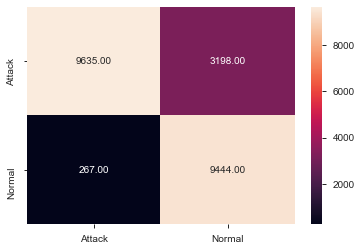

In [213]:
#3. Create confusion matrix
#for test

conn_cm_test = metrics.confusion_matrix(conn_data_test_new.attack, test_predicted, [1,0])
sns.heatmap(conn_cm_test, fmt= '.2f', annot=True,  xticklabels=['Attack', 'Normal'], yticklabels=['Attack', 'Normal'])

In [214]:
#4. Create classification report
print(metrics.classification_report(conn_data_test_new.attack, test_predicted))

              precision    recall  f1-score   support

           0       0.75      0.97      0.84      9711
           1       0.97      0.75      0.85     12833

    accuracy                           0.85     22544
   macro avg       0.86      0.86      0.85     22544
weighted avg       0.88      0.85      0.85     22544



In [215]:
#5. Find cross vaidated score

from sklearn.model_selection import cross_val_score

cvs = cross_val_score(rf, conn_data_test_new.drop(['attack'], axis = 1), test_predicted, cv =10)
print(cvs)

print(pd.Series(cvs).describe()[['min', 'max', 'std', 'mean']])

[0.99467849 0.99290466 0.99379157 0.99645233 0.99378882 0.99378882
 0.99334516 0.99378882 0.99556344 0.98935226]
min     0.989352
max     0.996452
std     0.001876
mean    0.993745
dtype: float64


In [216]:
indices = np.argsort(rf.feature_importances_)[::-1]
feature_rank = pd.DataFrame(columns = ['rank', 'feature', 'importance'])
for f in range(train_x.shape[1]):
    feature_rank.loc[f] = [f+1,
                          train_x.columns[indices[f]],
                          rf.feature_importances_[indices[f]]]
feature_rank.round(3)

,rank,feature,importance
0,1,src_bytes,0.156
1,2,flag_SF,0.101
2,3,dst_bytes,0.099
3,4,same_srv_rate,0.098
4,5,last_flag,0.060
5,6,dst_host_same_srv_rate,0.047
6,7,dst_host_diff_srv_rate,0.044
7,8,count,0.041
8,9,dst_host_srv_count,0.039
9,10,dst_host_srv_serror_rate,0.033


### Multiclass Classification

For this we can use Naive Bayes or Random Forest techniques as they tend to give better accuracies for multiclass classification

In [217]:
conn_attack_train.attack.head()

0     normal
1     normal
2    neptune
3     normal
4     normal
Name: attack, dtype: object

In [218]:
conn_data_train_new.attack = conn_attack_train.attack
conn_data_test_new.attack = conn_attack_test.attack

In [219]:
dos = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'udpstorm', 'processtable', 'worm']
probe = ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']
r2l = ['guess_password', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop',
       'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']
u2r = ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']

def attack_class(x):
    if(x.lower() in dos):
        x = 'DoS'
    else:
        if(x.lower() in probe):
            x = 'Probe'
        else:
            if(x.lower() in r2l):
                x = 'R2L'
            else:
                if(x.lower() in u2r):
                    x = 'U2R'
                else:
                    x = 'Normal'           
    return x

In [220]:
conn_data_train_new.attack = conn_data_train_new.attack.apply(lambda x : attack_class(x))

In [221]:
conn_data_test_new.attack = conn_data_test_new.attack.apply(lambda x : attack_class(x))

In [222]:
print(conn_data_train_new.attack.value_counts())
print(conn_data_test_new.attack.value_counts())

Normal    67396
DoS       45927
Probe     11656
R2L         942
U2R          52
Name: attack, dtype: int64
Normal    11235
DoS        7167
Probe      2421
R2L        1654
U2R          67
Name: attack, dtype: int64


In [223]:
conn_data_test_new.head()

,attack,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,...,num_access_files_2,num_access_files_3,num_access_files_4,num_access_files_5,num_access_files_6,num_access_files_7,num_access_files_8,num_access_files_9,is_host_login_1,is_guest_login_1
0,DoS,229,0.06,0.0,255,0.06,1.00,0.00,0.04,0.0,...,0,0,0,0,0,0,0,0,0,0
1,DoS,136,0.06,0.0,255,0.06,1.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Normal,1,0.00,0.0,134,0.04,0.00,0.61,0.61,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Probe,1,0.00,0.0,3,0.00,0.00,1.00,1.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Probe,1,0.00,15.0,29,0.17,0.83,0.03,0.31,0.0,...,0,0,0,0,0,0,0,0,0,0


### Divide dataset into train and test

In [224]:
feature_columns

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       ...
       'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate',
       'su_attempted_1', 'su_attempted_2', 'urgent_1', 'urgent_2', 'urgent_3',
       'wrong_fragment_1', 'wrong_fragment_3'],
      dtype='object', length=129)

In [225]:
train_multi_x, test_multi_x, train_multi_y, test_multi_y = train_test_split(conn_data_train_new[feature_columns],
                                                                           conn_data_train_new['attack'], test_size = 0.3,
                                                                           random_state =222 )

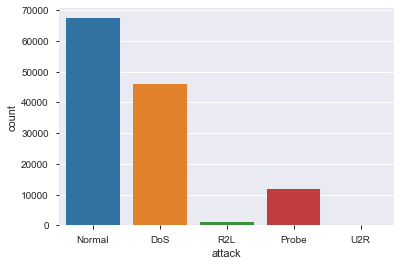

In [226]:
sns.countplot(conn_data_train_new.attack)
plt.show()

### Model building for multinomial classification

### Random Forest classifier

In [108]:
para_grid_multi_rf = {'n_estimators' : [70,80,90,100,110],
                      'max_features' : [10,11,12,13,14,15]}

gscv_multi_rf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=para_grid_multi_rf,
                       cv = 10,
                       verbose = 1,
                       n_jobs =-1)

gscv_multi_rf.fit(train_multi_x, train_multi_y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [227]:
#Score on train dataset
gscv_multi_rf.best_score_

0.9993195838867355

In [228]:
# Get the best parameters
gscv_multi_rf.best_params_

{'max_features': 14, 'n_estimators': 70}

In [229]:
gscv_multi_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [230]:
# Get the estimator
best_rf = gscv_multi_rf.best_estimator_

In [231]:
y_prediction = best_rf.predict(conn_data_test_new[feature_columns])

In [232]:
#accuracy & F-score on validation data

print("Accuracy score on testing data {:.4f}".format(metrics.accuracy_score(test_multi_y, best_rf.predict(test_multi_x))))

Accuracy score on testing data 0.9995


In [234]:
print(metrics.classification_report(test_multi_y, best_rf.predict(test_multi_x)))

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     13772
      Normal       1.00      1.00      1.00     20220
       Probe       1.00      1.00      1.00      3492
         R2L       0.99      0.98      0.98       294
         U2R       0.85      0.79      0.81        14

    accuracy                           1.00     37792
   macro avg       0.97      0.95      0.96     37792
weighted avg       1.00      1.00      1.00     37792



In [235]:
#accuracy & F-score on test data

print("Accuracy score on testing data {:.4f}".format(metrics.accuracy_score(conn_data_test_new.attack, y_prediction)))

Accuracy score on testing data 0.8301


In [236]:
print(metrics.classification_report(conn_data_test_new.attack, y_prediction))

              precision    recall  f1-score   support

         DoS       0.96      0.82      0.89      7167
      Normal       0.78      0.97      0.86     11235
       Probe       0.79      0.68      0.74      2421
         R2L       0.99      0.16      0.27      1654
         U2R       0.63      0.33      0.43        67

    accuracy                           0.83     22544
   macro avg       0.83      0.59      0.64     22544
weighted avg       0.85      0.83      0.81     22544



#### Naive Bayes

In [237]:
#GaussianNB because we have most of our variables as continous
from sklearn.naive_bayes import GaussianNB

In [238]:
nb_model = GaussianNB()
nb_model.fit(train_multi_x, train_multi_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [242]:
test_predicted_multi = nb_model.predict(conn_data_test_new[feature_columns])
test_predicted_multi

array(['Probe', 'Probe', 'Normal', ..., 'R2L', 'Normal', 'Probe'],
      dtype='<U6')

In [243]:
print(metrics.classification_report(train_multi_y, nb_model.predict(train_multi_x)))

              precision    recall  f1-score   support

         DoS       0.98      0.89      0.93     32155
      Normal       0.98      0.87      0.92     47176
       Probe       0.55      0.94      0.69      8164
         R2L       0.22      0.97      0.36       648
         U2R       0.12      0.74      0.21        38

    accuracy                           0.89     88181
   macro avg       0.57      0.88      0.62     88181
weighted avg       0.94      0.89      0.90     88181



In [244]:
print(metrics.classification_report(conn_data_test_new.attack, test_predicted_multi))

              precision    recall  f1-score   support

         DoS       0.86      0.55      0.67      7167
      Normal       0.91      0.85      0.88     11235
       Probe       0.42      0.89      0.57      2421
         R2L       0.45      0.60      0.52      1654
         U2R       0.03      0.06      0.04        67

    accuracy                           0.74     22544
   macro avg       0.53      0.59      0.53     22544
weighted avg       0.81      0.74      0.75     22544



Text(0.5, 12.5, 'Predicted')

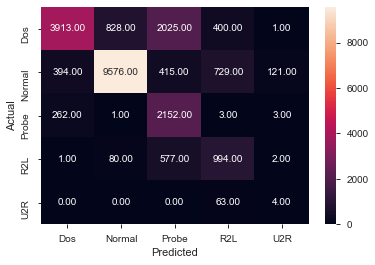

In [245]:
#confusion_matrix for test dataset
cm_test = metrics.confusion_matrix(conn_data_test_new.attack, test_predicted_multi)
sns.heatmap(cm_test, fmt = '.2f', annot = True, xticklabels=['Dos', 'Normal', 'Probe', 'R2L', 'U2R'],
            yticklabels=['Dos', 'Normal', 'Probe', 'R2L', 'U2R'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [246]:
accuracy = metrics.accuracy_score(train_multi_y, nb_model.predict(train_multi_x))
#AUC_ROC = metrics.roc_auc_score(train_multi_y, nb_model.predict_proba(train_multi_x), multi_class='ovr')
print("Accuracy score for train dataset %.3f" % (accuracy))
#print("AUC score %.3f" % (AUC_ROC))

Accuracy score for train dataset 0.886


In [247]:
accuracy = metrics.accuracy_score(conn_data_test_new.attack, test_predicted_multi)
#AUC_ROC = metrics.roc_auc_score(test_multi_y, nb_model.predict_proba(test_multi_x), multi_class='ovr')
print("Accuracy score for test dataset %.3f" % (accuracy))
#print("AUC score %.3f" % (AUC_ROC))

Accuracy score for test dataset 0.738
